In [1]:
import pandas as pd
import time, datetime, tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare
import pickle
import utils, plots, tools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use("style.mplstyle")

tools.make_poff(date_end=datetime.datetime(2024, 11, 29, 11, 50, 0), integration_time=60, ref="40525", save_path="/eos/user/j/jcapotor/RTDdata/calib/TGrad/PON")

In [2]:
tini = datetime.datetime(2024, 3, 1, 0, 0, 0)
tend = datetime.datetime(2024, 12, 31, 0, 0, 0)
data, data_err = utils.load_data(
    tini=tini,
    tend=tend
)
data, data_err = tools.apply_current_corr(data=data, data_err=data_err)

Text(0.5, 1.0, 'First Pumps-Off: Temperature Evolution')

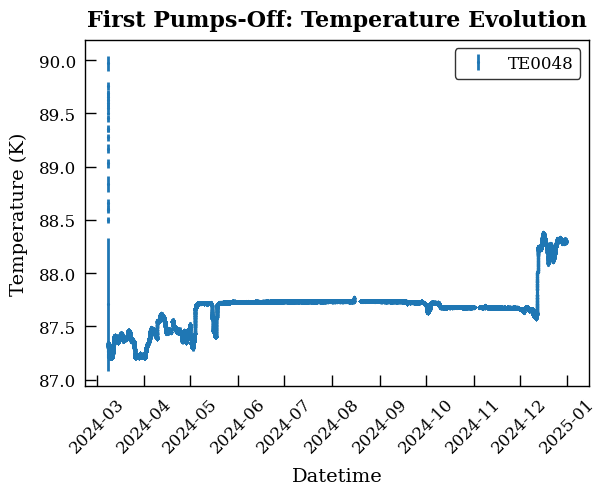

In [3]:
fig, axes = plt.subplots(1, 1)
plots.plot_temp_evolution(
    data=data, data_err=data_err, channel="TE0048",
    tmax=90, tmin=87.2, tmax_err=1,
    axes=axes
)
#axes.axvline(datetime.datetime(2024, 5, 3, 13, 30, 0), label="Recirculation ON", color="red")
# axes.axvline(datetime.datetime(2024, 12, 3, 14, 30, 0), label="Recirculation ON", color="orange")
# axes.axvline(datetime.datetime(2024, 5, 3, 10, 30, 0), label="Recirculation ON", color="red")
# axes.axvline(datetime.datetime(2024, 5, 2, 10, 8, 0), label=f"ALL CE ON: {datetime.datetime(2024, 5, 2, 10, 8, 0)}", color="green")
axes.legend()
axes.set_xlabel("Datetime")
axes.set_ylabel("Temperature (K)")
axes.set_title("First Pumps-Off: Temperature Evolution")
# fig.savefig(f"{path_to_save_plots}np04_temp_evolution_TE0001.png", format="png")

0.0008177865774852868


<ErrorbarContainer object of 3 artists>

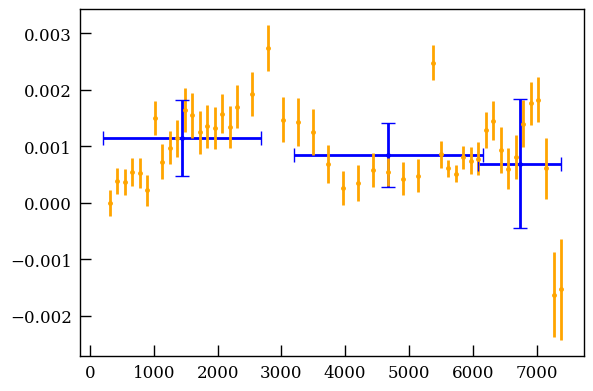

In [16]:
fig, axes = plt.subplots(1, 1)
profile = tools.make_tgrad_profile(
        data=data, data_err=data_err,
        date_ini=datetime.datetime(2024, 11, 26, 10, 50, 0), date_end=datetime.datetime(2024, 11, 26, 11, 50, 0),
        path_to_calib="/eos/user/j/jcapotor/RTDdata/calib/TGrad/PON/pon_2024-11-29 10:50:00_2024-11-29 11:50:00.pkl",
        ref="40525"
    )
profile["temp"] = profile["temp"] - profile["temp"].iloc[-1]
top = profile.loc[(profile["Y"]>6000)]
middle = profile.loc[(profile["Y"]>3000) & (profile["Y"]<6000)]
bottom = profile.loc[(profile["Y"]<3000)]

metric = np.average(
    a=np.array([top["temp"].mean(), middle["temp"].mean(), bottom["temp"].mean()]),
    weights=np.array([top["temp_err"].std(), middle["temp_err"].std(), bottom["temp_err"].std()])
    )
print(metric)
axes.errorbar(top["Y"].mean(), (top["temp"]).mean(), xerr=0.5*(top["Y"].max()-top["Y"].min()), yerr=top["temp"].std(), fmt="o", color="blue", label="Top", capsize=5)
axes.errorbar(middle["Y"].mean(), (middle["temp"]).mean(), xerr=0.5*(middle["Y"].max()-middle["Y"].min()), yerr=middle["temp"].std(), fmt="o", color="blue", label="Middle", capsize=5)
axes.errorbar(bottom["Y"].mean(), (bottom["temp"]).mean(), xerr=0.5*(bottom["Y"].max()-bottom["Y"].min()), yerr=bottom["temp"].std(), fmt="o", color="blue", label="Bottom", capsize=5)
axes.errorbar(profile["Y"].to_numpy(), (profile["temp"]).to_numpy(), yerr=profile["temp_err"].to_numpy(), fmt="o", color="orange", label="T-Profile")

In [ ]:
def chi_squared(observed, expected, errors):
    """
    Compute the chi-squared statistic given observed values, expected values, and errors.

    Parameters:
    observed (array-like): Observed temperature values
    expected (array-like): Expected temperature values
    errors (array-like): Uncertainties in observed values (or combined errors)

    Returns:
    float: Chi-squared value
    """
    return np.sum(((observed - expected) ** 2) / (errors ** 2))/len(observed)

def calculate_chi2(data, data_err,
                   date_ini1, date_end1, date_ini2, date_end2,
                   path_to_calib1="/eos/user/j/jcapotor/RTDdata/calib/TGrad/POFF/poff_2024-12-03 13:25:00_2024-12-03 14:25:00.pkl",
                   path_to_calib2="/eos/user/j/jcapotor/RTDdata/calib/TGrad/POFF/poff_2024-12-03 13:25:00_2024-12-03 14:25:00.pkl",
                   ref="40525"):

    calib1          = utils.load_calib(path=path_to_calib1)[ref]
    mapping_end1    = utils.load_mapping(date=date_end1)
    selection_end1  = mapping_end1.loc[(mapping_end1["SYSTEM"]=="TGRAD")]
    mapping_ini1    = utils.load_mapping(date=date_ini1)
    selection_ini1  = mapping_ini1.loc[(mapping_ini1["SYSTEM"]=="TGRAD")]
    equal1          = (selection_end1["SC-ID"].to_list() == selection_ini1["SC-ID"].to_list())

    calib2          = utils.load_calib(path=path_to_calib2)[ref]
    mapping_end2    = utils.load_mapping(date=date_end2)
    selection_end2  = mapping_end2.loc[(mapping_end2["SYSTEM"]=="TGRAD")]
    mapping_ini2    = utils.load_mapping(date=date_ini2)
    selection_ini2  = mapping_ini2.loc[(mapping_ini2["SYSTEM"]=="TGRAD")]
    equal2          = (selection_end2["SC-ID"].to_list() == selection_ini2["SC-ID"].to_list())

    if (equal1 and equal2):
        selection1 = selection_end1["SC-ID"].to_list()
        sensor_id1 = selection_end1["CAL-ID"].astype(int).astype(str).to_numpy()
        sample1 = data.loc[date_ini1:date_end1][selection1]
        sample1.columns = sensor_id1
        selection_end1.loc[:, "CAL-ID"] = selection_end1["CAL-ID"].astype(int).astype(str)
        selection_end1 = selection_end1.set_index("CAL-ID")
        profile1 = sample1.mean().sub(1e-3*calib1.loc[calib1.index.isin(sensor_id1)]["cc"], axis=0)
        profile_err1 = np.sqrt(sample1.sem()**2 + (1e-3 * calib1.loc[calib1.index.isin(sensor_id1)]["cc_err"])**2)

        profile1 = profile1.to_frame(name="temp")
        profile_err1 = profile_err1.to_frame(name="temp_err")

        profile1 = profile1.join(selection_end1, how="left")
        profile1 = profile1.join(profile_err1[["temp_err"]], how="left")

        selection2 = selection_end2["SC-ID"].to_list()
        sensor_id2 = selection_end2["CAL-ID"].astype(int).astype(str).to_numpy()
        sample2 = data.loc[date_ini2:date_end2][selection2]
        sample2.columns = sensor_id2
        selection_end2.loc[:, "CAL-ID"] = selection_end2["CAL-ID"].astype(int).astype(str)
        selection_end2 = selection_end2.set_index("CAL-ID")
        profile2 = sample2.mean().sub(1e-3*calib2.loc[calib2.index.isin(sensor_id2)]["cc"], axis=0)
        profile_err2 = np.sqrt(sample2.sem()**2 + (1e-3 * calib2.loc[calib2.index.isin(sensor_id2)]["cc_err"])**2)

        profile2 = profile2.to_frame(name="temp")
        profile_err2 = profile_err2.to_frame(name="temp_err")

        profile2 = profile2.join(selection_end2, how="left")
        profile2 = profile2.join(profile_err2[["temp_err"]], how="left")

        bottom_temp1 = profile1.loc["39607"]["temp"]
        bottom_temp2 = profile2.loc["39607"]["temp"]

        profile1["temp"] = profile1["temp"] - bottom_temp1
        profile2["temp"] = profile2["temp"] - bottom_temp2

        chi2 = chi_squared(observed=profile1["temp"].to_numpy(),
                           expected=profile2["temp"].to_numpy(),
                           errors=np.sqrt(profile1["temp_err"].to_numpy()**2 + profile2["temp_err"].to_numpy()**2)
                           )
        return chi2, profile1, profile2, bottom_temp1, bottom_temp2

chi2, prof1, prof2, bot1, bot2 = calculate_chi2(data, data_err,
               date_ini1=datetime.datetime(2024, 6, 1, 0, 0, 0), date_end1=datetime.datetime(2024, 6, 1, 1, 0, 0),
               date_ini2=datetime.datetime(2024, 12, 6, 10, 0, 0), date_end2=datetime.datetime(2024, 12, 6, 11, 0, 0)
               )

40.03222458436512


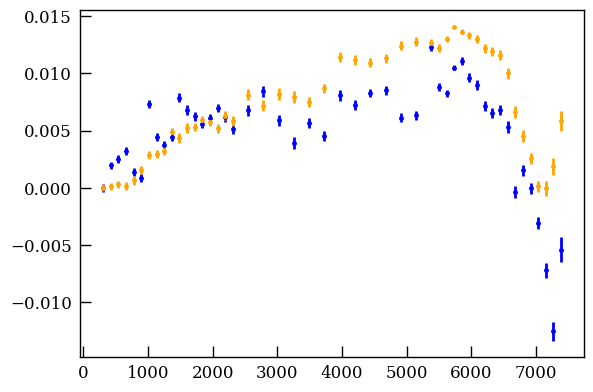

In [4]:
fig, axes = plt.subplots(1, 1)
axes.errorbar(prof1["Y"].to_numpy(), (prof1["temp"]).to_numpy(), yerr=prof1["temp_err"].to_numpy(), fmt="o", color="blue", label="Profile 1")
axes.errorbar(prof2["Y"].to_numpy(), (prof2["temp"]).to_numpy(), yerr=prof2["temp_err"].to_numpy(), fmt="o", color="orange", label="Profile 2")
print(chi2)

In [55]:
from IPython.display import clear_output
start = datetime.datetime(2024, 6, 1, 0, 0)  # June 1, 2024, 00:00
end = datetime.datetime(2024, 12, 5, 0, 0)    # July 1, 2024, 00:00

corr_data, corr_data_err = tools.apply_current_corr(data=data, data_err=data_err)
current = start
chi2_evo = {}
while current < end:
    print(current)
    try:
        chi2, prof1, prof2, bot1, bot2 = calculate_chi2(corr_data, corr_data_err,
                date_ini1=current - datetime.timedelta(hours=1), date_end1=current,
                date_ini2=datetime.datetime(2024, 11, 29, 10, 50, 0), date_end2=datetime.datetime(2024, 11, 29, 11, 50, 0)
                )
        chi2_evo[current] = {"chi2":chi2, "bot1":bot1, "bot2":bot2}
        current += datetime.timedelta(hours=1)
        clear_output(wait=True)
    except:
        current += datetime.timedelta(hours=1)
        continue
chi2_evo = pd.DataFrame(chi2_evo).T


2024-12-04 23:00:00


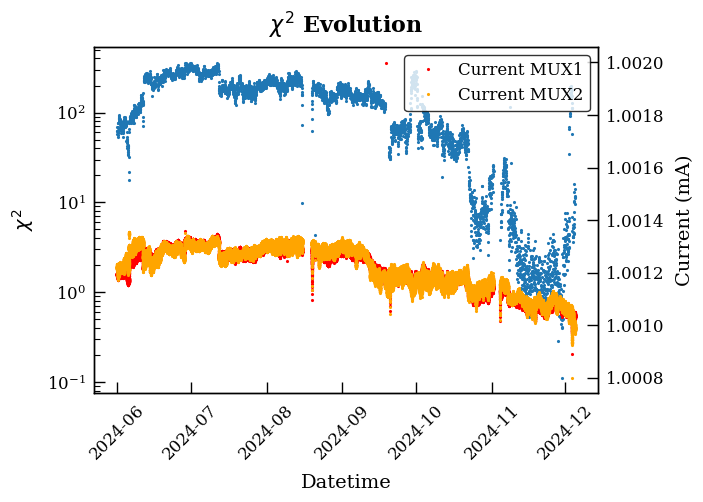

In [56]:

chi_plot = chi2_evo.loc[(chi2_evo["bot1"]<90)&(chi2_evo["chi2"]<1000)]
fig, axes = plt.subplots(1, 1)
axes.plot(chi_plot.index.to_numpy(), chi_plot["chi2"].to_numpy(),".", label="Chi2")
axes.set_xlabel("Datetime")
axes.set_ylabel(fr"$\chi^2$")
axes.set_title(fr"$\chi^2$ Evolution")
axes.set_yscale("log")
plt.xticks(rotation=45);
axes2 = axes.twinx()
axes2.plot(data.loc[(data.index>min(chi_plot.index))&(data.index<max(chi_plot.index))&(data["IE_Card01"]<1.1)&(data["IE_Card01"]>1)&(data["IE_Card02"]>1)].index.to_numpy(),
           data.loc[(data.index>min(chi_plot.index))&(data.index<max(chi_plot.index))&(data["IE_Card01"]<1.1)&(data["IE_Card01"]>1)&(data["IE_Card02"]>1)]["IE_Card01"].to_numpy(),
           # - data.loc[(data.index>min(chi_plot.index))&(data.index<max(chi_plot.index))&(data["IE_Card01"]<1.1)&(data["IE_Card01"]>1)&(data["IE_Card02"]>1)]["IE_Card02"].to_numpy(),
           ".", label="Current MUX1", color="red")
axes2.plot(data.loc[(data.index>min(chi_plot.index))&(data.index<max(chi_plot.index))&(data["IE_Card01"]<1.1)&(data["IE_Card01"]>1)&(data["IE_Card02"]>1)].index.to_numpy(),
           data.loc[(data.index>min(chi_plot.index))&(data.index<max(chi_plot.index))&(data["IE_Card01"]<1.1)&(data["IE_Card01"]>1)&(data["IE_Card02"]>1)]["IE_Card02"].to_numpy(),
           # - data.loc[(data.index>min(chi_plot.index))&(data.index<max(chi_plot.index))&(data["IE_Card01"]<1.1)&(data["IE_Card01"]>1)&(data["IE_Card02"]>1)]["IE_Card02"].to_numpy(),
           ".", label="Current MUX2", color="orange")
# axes2.plot(data.loc[(data.index>min(chi_plot.index))&(data.index<max(chi_plot.index))&(data["IE_Card01"]<1.1)&(data["IE_Card01"]>1)&(data["IE_Card02"]>1)].index.to_numpy(),
#            data.loc[(data.index>min(chi_plot.index))&(data.index<max(chi_plot.index))&(data["IE_Card01"]<1.1)&(data["IE_Card01"]>1)&(data["IE_Card02"]>1)]["IE_Card01"].to_numpy(),
#          - data.loc[(data.index>min(chi_plot.index))&(data.index<max(chi_plot.index))&(data["IE_Card01"]<1.1)&(data["IE_Card01"]>1)&(data["IE_Card02"]>1)]["IE_Card02"].to_numpy(),
#            ".", label="Current MUX2", color="orange")
axes2.set_ylabel("Current (mA)")
axes2.legend()